# A NOTEBOOK BY ABHINAV DARSI - [AB]

# Acknowledgements
This dataset was obtained from https://www.wunderground.com/</a>, at the Austin KATT station.

# Content
This dataset contains :
* Date (YYYY-MM-DD)
* TempHighF (High temperature, in Fahrenheit)
* TempAvgF (Average temperature, in Fahrenheit)
* TempLowF (Low temperature, in Fahrenheit)
* DewPointHighF (High dew point, in Fahrenheit)
* DewPointAvgF (Average dew point, in Fahrenheit)
* DewPointLowF (Low dew point, in Fahrenheit)
* HumidityHighPercent (High humidity, as a percentage)
* HumidityAvgPercent (Average humidity, as a percentage)
* HumidityLowPercent (Low humidity, as a percentage)
* SeaLevelPressureHighInches (High sea level pressure, in inches)
* SeaLevelPressureAvgInches (Average sea level pressure, in inches)
* SeaLevelPressureLowInches (Low sea level pressure, in inches)
* VisibilityHighMiles (High visibility, in miles)
* VisibilityAvgMiles (Average visibility, in miles)
* VisibilityLowMiles (Low visibility, in miles)
* WindHighMPH (High wind speed, in miles per hour)
* WindAvgMPH (Average wind speed, in miles per hour)
* WindGustMPH (Highest wind speed gust, in miles per hour)
* PrecipitationSumInches (Total precipitation, in inches) ('T' if Trace)
* Events (Adverse weather events. ' ' if None)

This dataset contains data for every date from 2013-12-21 to 2017-07-31.

# Outline
I made this kernel to get some experience with the general ML pipeline:
* Analyze and clean the data
* Preprocess the data
* Do feature selection/extraction
* Do model selection and evaluation using Advanced Techniques 

# Reading and preparing the data


In [2]:
import numpy as np
import pandas as pd



data = pd.read_csv('austin_weather.csv', parse_dates=['Date'])
print('DATA SHAPE: {}'.format(data.shape))
print('------------------------------------------------------------------')
print('FEATURES LIST AND TYPES:\n{}'.format(data.dtypes))
print('------------------------------------------------------------------')
print('NUMBER OF NaNs PER FEATURE:\n{}'.format(data.isnull().sum(axis=0)))
data.head(3)

DATA SHAPE: (1319, 21)
------------------------------------------------------------------
FEATURES LIST AND TYPES:
Date                          datetime64[ns]
TempHighF                              int64
TempAvgF                               int64
TempLowF                               int64
DewPointHighF                         object
DewPointAvgF                          object
DewPointLowF                          object
HumidityHighPercent                   object
HumidityAvgPercent                    object
HumidityLowPercent                    object
SeaLevelPressureHighInches            object
SeaLevelPressureAvgInches             object
SeaLevelPressureLowInches             object
VisibilityHighMiles                   object
VisibilityAvgMiles                    object
VisibilityLowMiles                    object
WindHighMPH                           object
WindAvgMPH                            object
WindGustMPH                           object
PrecipitationSumInches        

,Date,TempHighF,TempAvgF,TempLowF,DewPointHighF,DewPointAvgF,DewPointLowF,HumidityHighPercent,HumidityAvgPercent,HumidityLowPercent,...,SeaLevelPressureAvgInches,SeaLevelPressureLowInches,VisibilityHighMiles,VisibilityAvgMiles,VisibilityLowMiles,WindHighMPH,WindAvgMPH,WindGustMPH,PrecipitationSumInches,Events
0,2013-12-21,74,60,45,67,49,43,93,75,57,...,29.68,29.59,10,7,2,20,4,31,0.46,"Rain , Thunderstorm"
1,2013-12-22,56,48,39,43,36,28,93,68,43,...,30.13,29.87,10,10,5,16,6,25,0,
2,2013-12-23,58,45,32,31,27,23,76,52,27,...,30.49,30.41,10,10,10,8,3,12,0,


## Three important things to notice:
* There are no NaNs
* There are many features of type object, however, these are mostly numerical with the exception of feature 'Events'
* 'Events' uses a string to represent the weather for the day. The string ' ' (space) represents clear weather.

First i'm going to replace ' ' with 'Clear' to make the meaning of the value more *clear* (eheh) 

Secondly i'm going to add a feature: 'DayOfYear' which is the day of the year, meaning Jan 1 is day 1, Dec 31 is day 365 (assuming the year is not a leap year). This will make the calculations easier and will preserve the information the date brings to the dataset (since weather is seasonal) Note: this could be considered feature extraction.

Thirdly, even though there are no NaNs, the dataset documentation says that **in place of missing values there is the string '-'**. So i'm going to replace '-' with NaN and use an imputer to impute the missing values. Furthermore, **the feature 'PrecipitationSumInches' uses the value 'T' to represent trace amounts** of precipitation. To solve this problem i can either assign a value lower than the lowest value (e.g. 0.0005 since the lowest value is 0.01) or assign 0. I'll choose the first option since it seems the most correct.

In [3]:
# replacing ' ' with 'Clear'
data['Events'] = data['Events'].replace(' ', 'Clear')

# adding feature 'DayOfYear'
days_of_year = [date.dayofyear for date in data['Date']]
data['DayOfYear'] = days_of_year

data[['Date', 'DayOfYear', 'Events']].head(3)

,Date,DayOfYear,Events
0,2013-12-21,355,"Rain , Thunderstorm"
1,2013-12-22,356,Clear
2,2013-12-23,357,Clear


Now i'll replace '-' with NaN, 'T' with 0.0005 and use SimpleImputer to fill the missing values (NaNs).

In [4]:
from sklearn.impute import SimpleImputer

# printing '-' and 'T' count before removing them
number_of_nans = data.stack().value_counts()['-']
number_of_ts = data.stack().value_counts()['T']
print('BEFORE imputing and replacing, in the dataset there are {} "-" and {} "Ts"'.format(number_of_nans,number_of_ts))

# replacing '-' with NaN to later use SimpleImputer
data = data.replace('-', float('NaN'))
data['PrecipitationSumInches'] = data['PrecipitationSumInches'].replace('T', 0.0005)

# list of features to be checked for NaNs, imputing
to_be_imputed = list(set(data.columns)-set(['Date', 'Events']))

imp = SimpleImputer(missing_values=float('NaN'), strategy='mean')
data[to_be_imputed] = imp.fit_transform(data[to_be_imputed])

# printing '-' and 'T' count after removing them
if '-' not in data.stack().value_counts(): number_of_nans = 0
if 'T' not in data.stack().value_counts(): number_of_ts = 0
print('AFTER imputing and replacing, in the dataset there are {} "-" and {} "Ts"'.format(number_of_nans,number_of_ts))

BEFORE imputing and replacing, in the dataset there are 80 "-" and 124 "Ts"
AFTER imputing and replacing, in the dataset there are 0 "-" and 0 "Ts"


# Preprocessing: Scaling
Since this is meteorological data, i'm not expecting huge differences in values (considering a single feature), that is, i'm not expecting outlying values. However different features differ quite a bit in their values range. On top of that, many estimators expect the data to be standardized. For these reasons i choose to use the Min-Max scaler which follows the formula:

$$X_{sc} = \frac{X - X_{min}}{X_{max} - X_{min}}$$


Essentially what it does is shrink the range of values to [0, 1] or [-1, 1] if there are negative values

In [5]:
from sklearn.preprocessing import MinMaxScaler

# not all features need to be scaled: 'Date' and 'Events' don't need scaling. 
# 'Date' is just there for intepretability and will not be used for classification
# in its place 'DayOfYear' will be used. 
# 'Events' represents the class. 
# Therefore i prepare the list of feature names that need scaling to scale just those
# i keep the original data untouched to later make a comparison
scaled_data = data.copy()
to_be_scaled = list(set(data.columns)-set(['Date', 'Events']))
scaler = MinMaxScaler()
scaler.fit(data[to_be_scaled])
scaled_data[to_be_scaled] = scaler.transform(data[to_be_scaled])

# Preprocessing: Encoding Labels
To encode the target feature 'Events' i'm going to use LabelEncoder, an encoder specifically built to encode target variables. The encoder encodes each value to a value in [0, n_classes-1]

In [6]:
from sklearn.preprocessing import LabelEncoder

# encoding
preprocessed_data = scaled_data
encoder = LabelEncoder()
encoder.fit(scaled_data['Events'])
preprocessed_data['Events'] = encoder.transform(scaled_data['Events'])

# printing
classes_occurrences = preprocessed_data['Events'].value_counts().to_frame()
classes_occurrences['Class'] = encoder.inverse_transform(classes_occurrences.index)
classes_occurrences = classes_occurrences.sort_index(axis=0)
print(classes_occurrences)

   Events                      Class
0     903                      Clear
1      21                        Fog
2      14                 Fog , Rain
3      33  Fog , Rain , Thunderstorm
4       1         Fog , Thunderstorm
5     192                       Rain
6       1                Rain , Snow
7     137        Rain , Thunderstorm
8      17               Thunderstorm


We can notice that some classes are under represented with just a few examples.
For semplicity sake, i'll simplify the problem by adjusting the labeling by the following rule:

if that day it didn't rain, then label = 0

else if that day there was a thunderstorm, then label = 2

else label = 1

In [7]:
# relabeling
preprocessed_data['Events'] = preprocessed_data['Events'].replace([1], 0)
preprocessed_data['Events'] = preprocessed_data['Events'].replace([2,5,6], 1)
preprocessed_data['Events'] = preprocessed_data['Events'].replace([3,4,7,8], 2)

# printing classes and number of occurrences
classes_occurrences = preprocessed_data['Events'].value_counts().to_frame()
classes_occurrences['Class'] = ['Clear', 'Rain', 'Thunderstorm']
classes_occurrences = classes_occurrences.sort_index(axis=0)
print(classes_occurrences)

   Events         Class
0     924         Clear
1     207          Rain
2     188  Thunderstorm


# Original data vs scaled data
For curiosity's sake (and as an excuse for plotting stuff) i'll plot the same scatter plot with the original and scaled features. The features i chose are: Humidity and Precipitation. Being both measured with positive values, min-max scaler scales the values in the range [0, 1]. The color of the data points drawn is based on the class they are example of.

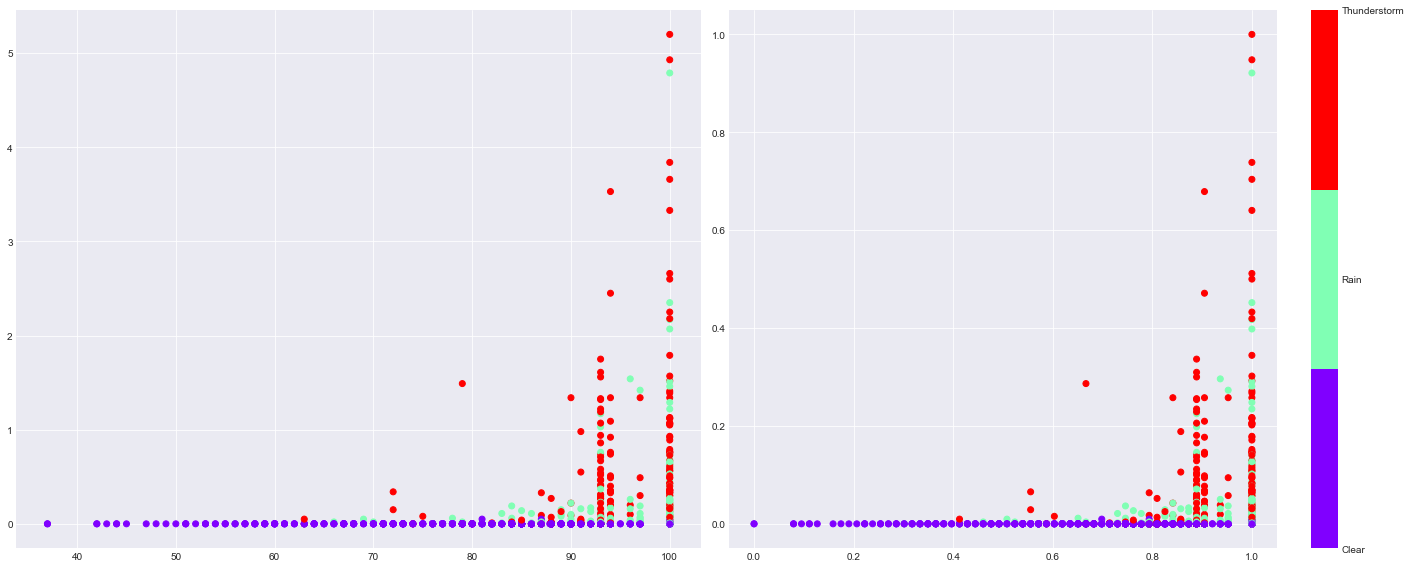

In [8]:
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
plt.style.use('seaborn-darkgrid')

x_axis_original = data['HumidityHighPercent']
y_axis_original = data['PrecipitationSumInches']

x_axis_scaled = preprocessed_data['HumidityHighPercent']
y_axis_scaled = preprocessed_data['PrecipitationSumInches']

rainbow = cm.get_cmap('rainbow', 3)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
axes[0].scatter(x_axis_original, y_axis_original, c=preprocessed_data['Events'], cmap=rainbow)
right_plot = axes[1].scatter(x_axis_scaled, y_axis_scaled, c=preprocessed_data['Events'], cmap=rainbow)
cbar = fig.colorbar(right_plot, ticks=[0, 1, 2])
cbar.ax.set_yticklabels(classes_occurrences['Class'])
plt.tight_layout()

# Feature Extraction/Selection: PCA

* In a nutshell PCA finds a new set of axes that maximizes the variance in the data. The axes are ordered such that the variance in axis_i is greater than the variance in axis_i+1.
* By taking the first N axes then, we will have the N axes that better represent the data.
* In this case, i only have 20 features, and all of them are quite relevant. Using PCA may be overkill.
* However to experiment with PCA, i'll keep 20 components, and then train the classification algorithm iteratively with increasing number of components, to see the effects on the performances.

In [9]:
from sklearn.decomposition import PCA

features = list(set(preprocessed_data.columns)-set(['Date', 'Events']))

# the set of first 10 features extracted with PCA
pca = PCA(n_components=len(features))
pca.fit(preprocessed_data[features])
X_PCA = pd.DataFrame(data=pca.transform(preprocessed_data[features]))

y = preprocessed_data['Events']

print('X_PCA shape: {}'.format(X_PCA.shape))

X_PCA shape: (1319, 20)


# SVC - Support Vector Classifier, testing different numbers of principal components
Scikit-learn offers an SVC implementation that supports multiclass problems which are handled using the one vs one technique.
In this section, i test the behaviour of SVC with an increasing number of principal components.


In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# function i'll use later to asses the model's performances
def evaluate(y_test, y_pred, avg):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=avg)
    recall = recall_score(y_test, y_pred, average=avg)
    f1 = f1_score(y_test, y_pred, average=avg)

    return (accuracy, precision, recall, f1)

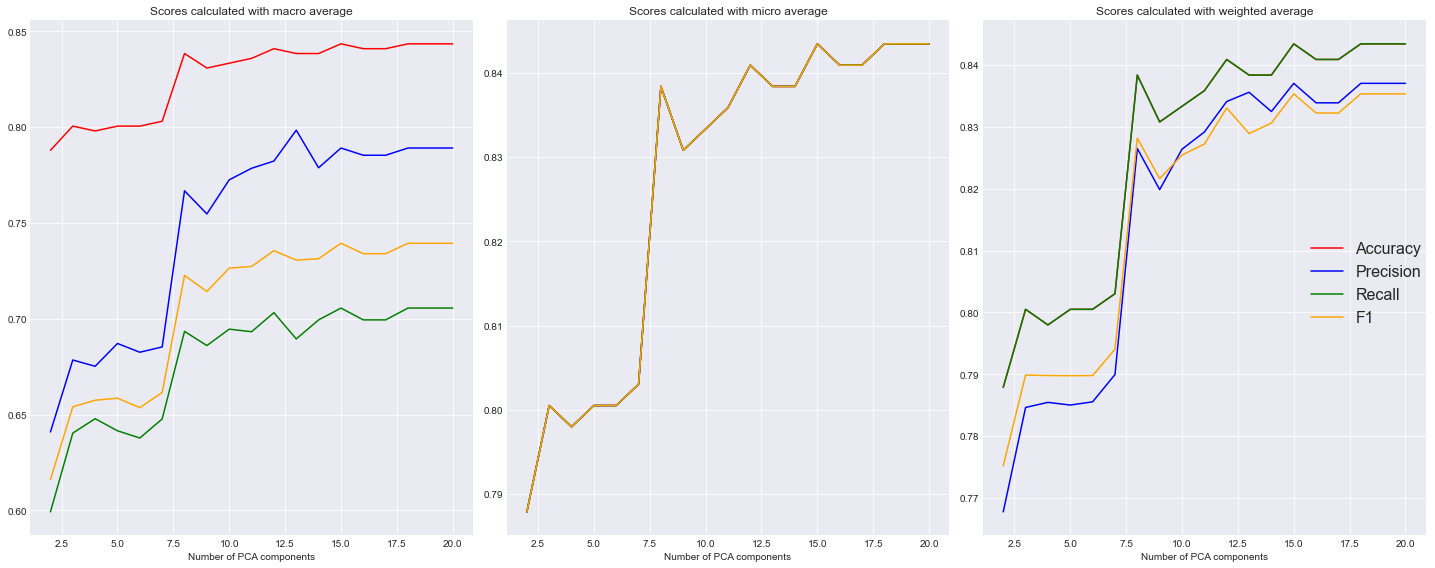

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# for storing scores
accuracies = []
precisions = [[],[],[]]
recalls = [[],[],[]]
f1s = [[],[],[]]
# different ways of calculating the average
avgs = ['macro', 'micro', 'weighted']

# each iteration increases by one the number of principal components used for the training
for i in range(2, 21):
    X_train, X_test, y_train, y_test = train_test_split(X_PCA[X_PCA.columns[:i]], y, test_size=0.3, random_state=0) # 70 - 30 split
    clf = SVC(gamma='auto', kernel='linear')
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    
    # saving scores for later plotting
    for j in range(len(avgs)):
        acc, prec, rec, f1 = evaluate(y_test, predictions, avgs[j])
        precisions[j].append(prec)
        recalls[j].append(rec)
        f1s[j].append(f1)   
        if j==0:
            accuracies.append(acc)


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))
lines = []
for i in range(3):
    l1=axes[i].plot(range(2,21), accuracies, color='red')[0]
    l2=axes[i].plot(range(2,21), precisions[i], color='blue')[0]
    l3=axes[i].plot(range(2,21), recalls[i], color='green')[0]
    l4=axes[i].plot(range(2,21), f1s[i], color='orange')[0]
    lines = [l1, l2, l3, l4]
    axes[i].set_title('Scores calculated with {} average'.format(avgs[i]))
    axes[i].set(xlabel='Number of PCA components')
fig.legend(lines, ['Accuracy', 'Precision', 'Recall', 'F1'], loc='center right', fontsize=16)
plt.tight_layout()

Here we can see how using different ways of calculating the average (for multiclass problems) affects the scores. The scores used are:

* Accuracy: $$ \frac{Correct\ Predictions}{Total\ Predictions} $$
* Precision: $$ \frac{True\ Positive}{True\ Positive\ +\ False\ Positive} $$
* Recall: $$ \frac{True\ Positive}{True\ Positive\ +\ False\ Negative} $$
* F1: $$ 2\ ⋅\ \frac{Precision\ ⋅\ Recall}{Precision\ +\ Recall} $$

Accuracy is the simplest score but can be misleading when the number of examples of different classes are disproportionate.

Precision should be maximized when it's important to minimize false positives

Recall should be maximized when it's important to minimize false positives

F1 is an instance of F Measure where β = 1. Given the definition of F measure:

$$ (1+β^2)\ ⋅\ \frac{Precision\ ⋅\ Recall}{(β^2\ ⋅\ \ Precision)\ +\ Recall} $$

When β > 1 the F measure weighs recall higher, when β < 1 the F measure weighs precision higher.

To get a better idea of what's going on, i'll print the **confusion matrix** of SVC on 8 principal components.

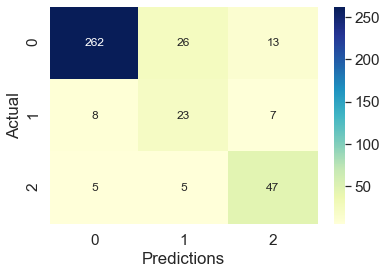

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_PCA[X_PCA.columns[:8]], y, test_size=0.3, random_state=0) # 70 - 30 split
clf = SVC(gamma='auto', kernel='linear')
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
confusion_matrix = pd.crosstab(predictions, y_test, rownames=['Actual'], colnames=['Predictions'])

import seaborn as sn

sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix, annot=True,annot_kws={"size": 12}, fmt="d", cmap="YlGnBu")
plt.show()

As we can see, the model isn't very good at classifying rain: it gets right 23 examples, but classifies 7 true rains as thunderstorms and 8 as clear weather.

# Model Selection: KFold nested cross validation
From the plots above 15 seems a reasonable number of components to keep.

In this section i use KFold and GridSearchCV to make model selection.

KFold takes the data and returns the indeces neccessary to divide it in K folds. K-1 folds will be used as training set and 1 as test set. Iteratively each fold will be used once as test set.

GridSearchCV uses an estimator with the given grid of parameters.

In [13]:
from sklearn.model_selection import GridSearchCV, KFold
from time import gmtime, strftime

# converting to numpy array to do THIS later
X = X_PCA[X_PCA.columns[:15]].to_numpy()

# sets of parameters to be tested
kernels = ['rbf', 'poly', 'linear', 'sigmoid']
cs = [2**i for i in range(1, 5)]
degrees = [i for i in range(2, 5)]
gammas = ['auto', 'scale']
coef0s = [2**i for i in range(1, 5)]
parameters = {'kernel': kernels, 'C': cs, 'degree': degrees, 'gamma':gammas, 'coef0': coef0s}
scores = []

folds = KFold(n_splits=5, shuffle=True, random_state=0)

i = 0
print('Starting at: {}'.format(strftime("%H:%M:%S", gmtime())))
print('')
for train_index, test_index in folds.split(X):
    print('Working on {}-th fold... '.format(i))
    i+=1
    
    # THIS can't be (this easily) done with a DataFrame
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    svc = SVC()
    clf = GridSearchCV(svc, parameters, cv=5, scoring='accuracy')
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)

    scores.append({'best_score': clf.best_score_, 'best_param': clf.best_params_})
print('')
print('Ending at: {}'.format(strftime("%H:%M:%S", gmtime())))
print('')

max_score = 0
best_params = {}
for score in scores:
    acc = score['best_score']
    params = score['best_param']
    if(acc > max_score):
        max_score = acc
        best_params = params
    print('Best_Score {}'.format(acc))
    print('Parameters {}'.format(params))

Starting at: 00:58:56

Working on 0-th fold... 
Working on 1-th fold... 
Working on 2-th fold... 
Working on 3-th fold... 
Working on 4-th fold... 

Ending at: 01:08:09

Best_Score 0.8189573459715641
Parameters {'C': 8, 'coef0': 16, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}
Best_Score 0.833175355450237
Parameters {'C': 8, 'coef0': 16, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}
Best_Score 0.8417061611374408
Parameters {'C': 8, 'coef0': 8, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
Best_Score 0.8464454976303317
Parameters {'C': 4, 'coef0': 8, 'degree': 4, 'gamma': 'auto', 'kernel': 'poly'}
Best_Score 0.8390145756952517
Parameters {'C': 16, 'coef0': 16, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}


I'll now train a model using the most promising parameters

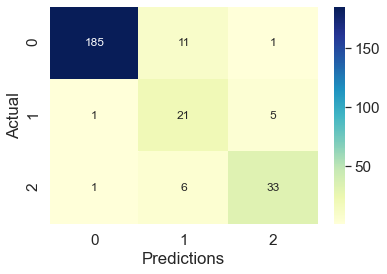

,Average,Accuracy,Precision,Recall,F1
0,macro,0.905303,0.847288,0.796030,0.815046
1,micro,0.905303,0.905303,0.905303,0.905303
2,weighted,0.905303,0.899014,0.905303,0.898933


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_PCA[X_PCA.columns[:15]], y, test_size=0.2, random_state=0)

clf = SVC(kernel=best_params['kernel'], C=best_params['C'], degree=best_params['degree'], gamma=best_params['gamma'], coef0=best_params['coef0'])
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

confusion_matrix = pd.crosstab(predictions, y_test, rownames=['Actual'], colnames=['Predictions'])

sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix, annot=True,annot_kws={"size": 12}, fmt="d", cmap="YlGnBu")
plt.show()

# different ways of calculating the average
avgs = ['macro', 'micro', 'weighted']

accuracies = []
precisions = []
recalls = []
f1s = []
# saving scores for later plotting
for j in range(len(avgs)):
    acc, prec, rec, f1 = evaluate(y_test, predictions, avgs[j])
    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)   
    accuracies.append(acc)

scores = {'Average': avgs, 'Accuracy': accuracies, 'Precision': precisions, 'Recall': recalls, 'F1': f1s}
scores_df = pd.DataFrame(data=scores)
scores_df.head(3)

The Prediction results obtained looks Good